### Solving Differential Equations with differentiable Quantum Circuits
This notebook shows an approach to solving arbitrary differential equation in one variable $t$ of the form:<br>
$f(t)=\bra{f}\hat{O}\ket{f}$ <br>
Where $\hat{O}$ is a Hermitian operator, and $\ket{f}$ encodes a dependence on two variables: <br>
-  $t$: the variable of differentiation.
- $\vec{\theta}$: an array of trainable parameters such that, after training, $f(t)\simeq\bra{f}\hat{O}\ket{f}$.
 
In this notebook, $\ket{f}=\text{U}(\vec{\theta,t})\ket{0, 0\,...\, 0}$ <br>
$\frac{df(t)}{dt}$ is computed in terms of $\ket{f}$ and $\hat{O}$ with the Parameter Shift Rule.

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import time as tm
import pylab as pl
from scipy.integrate import solve_ivp
from IPython import display
from typing import Union

# Operator Imports
from qiskit.opflow.list_ops.composed_op import ComposedOp
from qiskit.opflow.list_ops.summed_op import SummedOp
from qiskit.opflow import Z, StateFn, CircuitStateFn
from qiskit.opflow.gradients import Gradient

# Circuit imports
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

# Optimizers
from qiskit.algorithms.optimizers import COBYLA, ADAM

In [ ]:
# # Defining variables for the parametrized circuit.

# # number of qubits
# n_q = 1
# n_params = 5
# c = 'nuovo'
# n=4
# # t is the time variable.
# # theta is a vector of adjustable parameters used to fit arbitrary equations.
# t = Parameter("t")
# theta = ParameterVector("theta",21)


# print(f"{n_q} qubits")
# print(f"{n*2} theta params")

# # ansatz is a unitary circuit parametrized by the theta vector, which provides adaptability to many differential equations.
# ansatz = QuantumCircuit(n_q)

# ansatz.ry(t*theta[0]+theta[1],0)
# ansatz.ry(t*theta[2]+theta[3],1)
# ansatz.ry(t*theta[4]+theta[5],2)


# ansatz.draw('mpl')

# Circuit 1
$\tt RY(t\cdot\theta_0+\theta_1)\hspace{1cm}\forall$ qubit

# Circuit 2
$\tt RY(t\cdot\theta_0+\theta_1)\hspace{1cm}\forall$ qubit

$\tt CNOT\hspace{2.5cm}$ with the next qubit as target and the previous qubit as control

# Circuit 3
$\tt RY(t\cdot\theta_0+\theta_1)\hspace{1cm}\forall$ qubit

$\tt CRX(\theta_2)\hspace{2cm}$ with the next qubit as target and the previous qubit as control

# Circuit 4

$\tt RY(t\cdot\theta_0+\theta_1)\hspace{1cm}\forall$ qubit

$\tt CRX(t\cdot\theta_2)\hspace{1cm}$ with the next qubit as target and the previous qubit as control


1 qubits
3 theta params
#1 quantum circuit


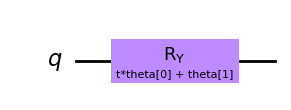

In [3]:
# Defining variables for the parametrized circuit.

# number of qubits
n_q = 1

# circuit #1, #2, #3 or #4
circ = 1


# t is the time variable.
t = Parameter("t")

k = [[0,n_q*2+1],[0,n_q*2+1],[1,n_q*3],[t,n_q*3]]


# theta is a vector of adjustable parameters used to fit arbitrary equations.
n_params = k[circ-1][1]
theta = ParameterVector("theta",n_params)
print(f"{n_q} qubits")
print(f"{n_params} theta params")
print(f"#{circ} quantum circuit")

# ansatz is a unitary circuit parametrized by the theta vector, which provides adaptability to many differential equations.
ansatz = QuantumCircuit(n_q)
for i in np.arange(n_q):
    ansatz.ry(theta[2*i]*t+ theta[2*i+1], i)    
    if i < n_q-1: 
        if circ == 2:
            ansatz.cx(i,i+1) 
        elif circ in [3,4]:
            ansatz.crx(k[circ-1][0]*theta[2*n_q+i],i,i+1) 

ansatz.draw('mpl')


Define a Hermitian observable to apply to the ansatz:

In [4]:
# Adding a Hermitian observable
observable = theta[-1]*Z 
for i in np.arange(n_q-1):
    observable = observable ^Z
print(f"Observable: {observable}")

# Creating a ComposedOp object, containing the Hermitian operator and the theta-t embedding.
op = ~StateFn(observable) @ CircuitStateFn(primitive=ansatz)

Observable: 1.0*theta[2] * Z


Create the quantum circuits for describing gradients of the function:

In [5]:
# Creating first and second derivative generators from op with the parameter shift rule.
first_derivative = Gradient(grad_method = 'param_shift').convert(operator = op, params = t)
second_derivative = Gradient(grad_method = 'param_shift').convert(operator = first_derivative, params = t)

Method to calculate the expectation value $\bra{f}\hat{O}\ket{f}$ at each time point with fixed theta parameters.

In [6]:
def evaluate_function(time: Parameter, weights: ParameterVector, operator: Union[ComposedOp, SummedOp]) -> np.float64:
    """Returning the expectation value of a circuit"""
    expval = operator.assign_parameters({t:time, theta: weights}).eval()
    if np.abs(expval.imag) > 1e-5:
        print("Expectation value has imaginary part. Check Hermitianity") 
    return expval.real

Classical processing for the search of optimal quantum parameters.

Optimization algorithm: COBYLA

Initial parameter: random assignment between 0 and 0.1.

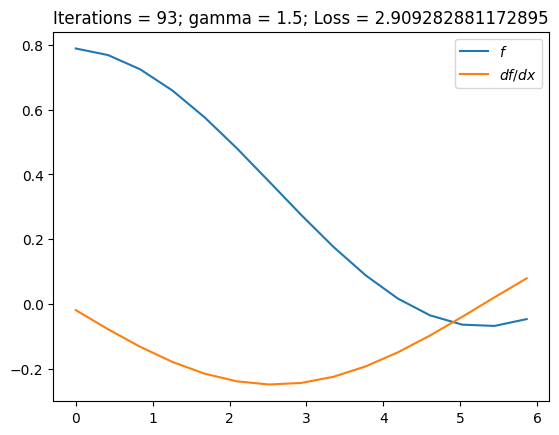

<Figure size 640x480 with 0 Axes>

Loss: 2.909282881172895
best_params: [0.57840657 0.07526571 0.42925485 0.36030875]


<Figure size 640x480 with 0 Axes>

In [8]:
# Training vector weights to approximate the target function.

# theta entries are initialized randomly. An additional weight helps the circuit to learn initial conditions.
initial_point = 0.1*np.random.rand(theta._size+1)
# initial_point = best_params[-1]

pt_nb = 15 # Reference points in a time grid
tgrid = np.arange(pt_nb)/pt_nb*2*np.pi # t from 0 to 2pi

losses = [] # List of losses (will quantify the circuit approximation to f(t))
best_params = []

# Coefficients and initial conditions of the differential equation of a damped harmonic oscillator
a = 1.5 #gamma
b = 1 #omega_0
c = 0
t0 = 0
u0 = 0.8
du0 = 0

# Loss function definition
def loss(x):
    
    f = np.zeros(pt_nb)
    df = np.zeros(pt_nb)
    ddf = np.zeros(pt_nb)
    loss_ct = 0
    
    for i, t in enumerate(tgrid):
        f[i] = evaluate_function(t, x[:-1], op) + x[-1]
        df[i] = evaluate_function(t, x[:-1], first_derivative) 
        ddf[i] = evaluate_function(t, x[:-1], second_derivative) 
        loss_ct = loss_ct + np.abs(ddf[i] + a*df[i] + b*f[i] + c)
    f0 = evaluate_function(t0, x[:-1], op) + x[-1] # Introducing initial condition f(0) = 0.8
    df0 = evaluate_function(t0, x[:-1], first_derivative) # Introducing initial condition f'(0) = 0

    loss_val = loss_ct + 10*pt_nb*(f0 - u0)**2 + 10*pt_nb*(df0 - du0)**2

    losses.append(loss_val) 
    best_params.append(x)


    display.clear_output(wait=True)
    # Plot that updates at every learning step.
    pl.plot(tgrid, f)
    pl.plot(tgrid, df)
    #pl.plot(tgrid, ddf)
    plt.title(f"Iterations = {len(losses)}; gamma = {a}; Loss = {loss_val}")
    plt.legend([r"$f$",r"$df/dx$"])
    pl.show()
    display.display(pl.gcf()) 
    tm.sleep(0.01)
    print('Loss:',loss_val)
    print('best_params:',best_params[-1])
    return loss_val


# Defining the optimization approach.
optimizer = COBYLA(maxiter = 1000, tol = 1e-4, rhobeg = 0.1)
# optimizer = ADAM(maxiter = 500, tol = 1e-4, lr = 0.05)

# Running the optimization
result = optimizer.minimize(fun = loss, x0 = initial_point)

Comparison between RK45 solution and quantum solution:

In [19]:
tdata = np.linspace(0, 2*np.pi, 100)

In [25]:
def DHO(t,y,gamma,om_0):
    return [y[1], - gamma * y[1] - om_0**2 * y[0]]

tspan = [tdata[0], tdata[-1]]
ic = [u0, du0]
rk45_sol = solve_ivp(fun = DHO, t_span = tspan, y0 = ic, method = 'RK45', t_eval = tdata, args = (a, b))

In [26]:
results = best_params[-1]

quantum_f = np.zeros(tdata.shape[0])
for i, x in enumerate(tdata):
    quantum_f[i] = evaluate_function(x, results[:-1], op) + results[-1]

Loss as a function of iterations:

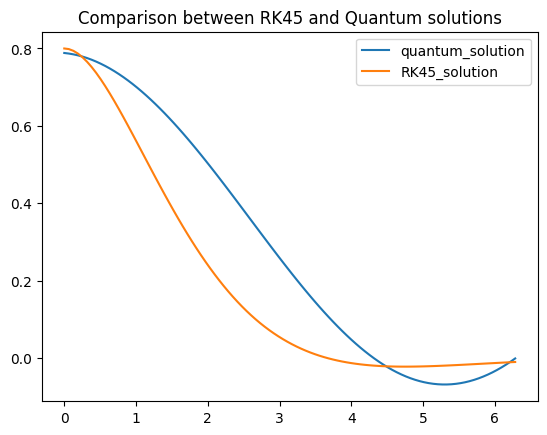

In [29]:
plt.plot(tdata, quantum_f,label="quantum_solution")
plt.plot(tdata, rk45_sol.y[0],label="RK45_solution")
plt.title('Comparison between RK45 and Quantum solutions')
plt.legend()
plt.show()

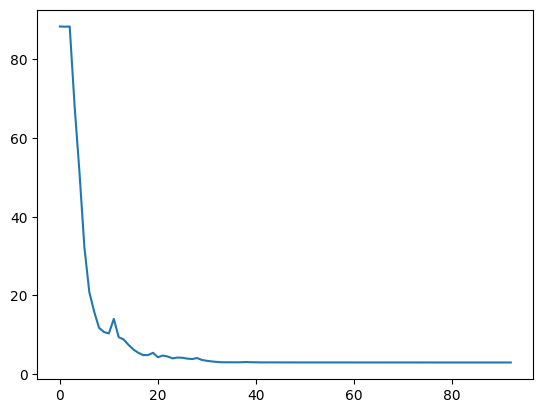

In [13]:
plt.plot(losses)

In [28]:
RSS = 0
for i in range(len(tdata)):
    RSS = RSS + (quantum_f[i]-rk45_sol.y[0][i])**2
print('RSS =',RSS)

RSS = 2.1464290018050676
